<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import warnings

import nltk
from nltk.corpus import stopwords
import re

from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot, TimeDistributed
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback

from gensim.models import Word2Vec

from matplotlib import pyplot as plt

In [21]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [23]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
leaves = nltk.corpus.gutenberg.raw('whitman-leaves.txt')
len(thurs), len(leaves)

(320525, 711215)

In [24]:
thurs = thurs.split('\n\n')
leaves = leaves.split('\n\n')
len(thurs), len(leaves)

(1304, 2867)

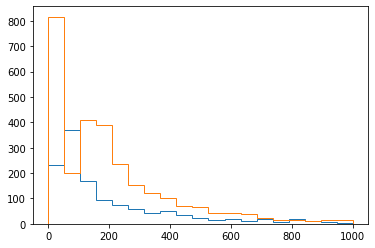

In [25]:
plt.hist([len(d) for d in thurs], bins=np.linspace(0,1000,20), histtype='step')
plt.hist([len(d) for d in leaves], bins=np.linspace(0,1000,20), histtype='step')
plt.show()

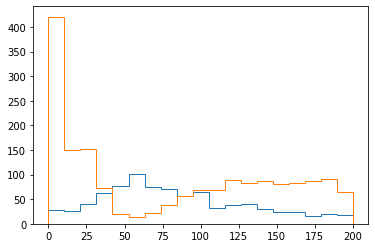

In [26]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.hist([len(d) for d in leaves if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.show()

In [27]:
len([d for d in thurs if len(d)>50]), len([d for d in leaves if len(d)>50])

(1084, 2054)

In [0]:
texts = [d for d in thurs if len(d)>50]+[d for d in leaves if len(d)>50]

In [0]:
texts = [' '.join(d.split()) for d in texts]
texts = [d for d in texts if len(d)>50]

In [30]:
texts[10]

"The man with the meek blue eyes and the pale, pointed beard endured these thunders with a certain submissive solemnity. The third party of the group, Gregory's sister Rosamond, who had her brother's braids of red hair, but a kindlier face underneath them, laughed with such mixture of admiration and disapproval as she gave commonly to the family oracle."

In [0]:
sents = '\n'.join(texts)
sents = nltk.tokenize.sent_tokenize(sents)

In [0]:
def doc2words(doc):
  words = nltk.tokenize.word_tokenize(doc)
  words = [w.lower() for w in words if w.isalpha()]
  words = [w for w in words if (len(w)>1) and (w not in stopwords)]
  return words

In [0]:
sents = [doc2words(s) for s in sents]
sents = [s for s in sents if len(s)>0]

In [0]:
emb = Word2Vec(sents)

In [35]:
emb.wv.similar_by_word('door')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('days', 0.9998558759689331),
 ('rest', 0.9998527765274048),
 ('world', 0.9998525977134705),
 ('come', 0.9998481273651123),
 ('time', 0.9998477697372437),
 ('children', 0.9998476505279541),
 ('work', 0.9998465776443481),
 ('silent', 0.9998456239700317),
 ('many', 0.9998433589935303),
 ('head', 0.9998427629470825)]

In [0]:
we = {w:emb.wv.get_vector(w) for w in emb.wv.vocab}
vec_size = emb.vector_size

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TLMDataGen:
  def __init__(self, documents, word_embedding, doc2words, lm_length, token2idx, vector_size,
               valid_num=None, valid_frac=None, batch_size=20, valid_batch_size=100):
    if valid_num is None and valid_frac is None:
      if len(documents) < 1000:
        valid_num = int(0.1*len(documents))
      else:
        valid_num = 100
    elif valid_num is None:
      valid_num = int(valid_frac*len(documents))

    perm = np.random.permutation(len(documents))
    self.train_idxs = perm[:valid_num]
    self.valid_idxs = perm[valid_num:]

    rep = {'<':'*', '>':'*'}
    rep = {re.escape(k):v for k,v in rep.items()}
    pattern = re.compile('|'.join(rep.keys()))

    self.documents = ['<'*lm_length+pattern.sub(lambda m: rep[re.escape(m.group(0))], d)+'>' for d in documents]
    self.batch_size = batch_size
    self.valid_batch_size = valid_batch_size
    self.word_embedding = word_embedding
    self.doc2words = doc2words
    self.lm_length = lm_length
    self.token2idx = token2idx
    self.vector_size = vector_size

  def get_train_batch(self):
    doc_idxs = np.random.choice(self.train_idxs, size=self.batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(self.lm_length+1, len(d)) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[i-self.lm_length-1:i] for i, d in zip(finish_idxs, docs)]
    lm_docs = np.array([[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    return [x_topic, lm_docs[:,:-1]], lm_docs[:,1:]

  def get_valid_batch(self):
    doc_idxs = np.random.choice(self.valid_idxs, size=self.valid_batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(self.lm_length+1, len(d)) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[i-self.lm_length-1:i] for i, d in zip(finish_idxs, docs)]
    lm_docs = np.array([[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    return [x_topic, lm_docs[:,:-1]], lm_docs[:,1:]


class TopicalLanguageModel:
  """
  Neural Topical Language Model.

  attributes:
  num_topics :: int : number of topics
  doc2words :: function : takes a document as a string and returns words
  word_embedding :: dict : keys are words, values are vectors
  vector_size :: int : the dimension of embedding vectors
  lm_length :: int : length of tokens taken into account for character-level language models 
  """
  def __init__(self, num_topics, word_embedding, vector_size, doc2words, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz '):
    self.num_topics = num_topics
    self.doc2words = doc2words
    self.word_embedding = word_embedding
    self.vector_size = vector_size
    self.lm_length = lm_length

    self.tokens = ['<', '>', '*'] + list(tokens)
    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))]+[('<',0),('>',1),('*',2)]
    self.token2idx = {t:k for t,k in token_idx}
    self.idx2token = {k:t for t,k in token_idx}

    self.num_tokens = len(tokens)+3

  def fit(self, documents, batch_size=20, epochs=10, verbose=0, examples_per_epoch=5, example_epoch_skip=1, num_validation_samples=5):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.vector_size,))
    h_topic = Dense(self.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens, return_sequences=True)(h_lm)
      h_lm = LSTM(self.num_tokens, return_sequences=True)(h_lm)
      out_lm = TimeDistributed(Dense(self.num_tokens, activation='softmax'))(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.lm_length, self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=3)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(3, 1), name='mixed_out')([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=[out, topic_mix])

    def mix_loss(y_true, y_pred):
      eps = 1e-10
      mean = K.mean(y_pred, axis=0)

      mean_nentropy = K.mean(K.sum(y_pred*K.log(y_pred+eps), axis=1))
      nentropy_mean = K.sum(mean*K.log(mean+eps))
      return nentropy_mean - mean_nentropy
      

    self.train_model.compile('adam', ['sparse_categorical_crossentropy', mix_loss])

    data_generator = TLMDataGen(documents, word_embedding=self.word_embedding, 
                                doc2words=self.doc2words, 
                                lm_length=self.lm_length, 
                                token2idx=self.token2idx,
                                vector_size=self.vector_size,
                                batch_size = batch_size)

    steps_per_epoch = len(documents)//batch_size
    self.logs = {'examples':[], 'val_loss':[], 'topic_fraction':[], 'topic_entropy':[]}
    for epoch in range(epochs+1):

      #examples
      if epoch%example_epoch_skip == 0:
        if verbose>1:
          print('Getting examples')
        for t in range(self.num_topics):
          for k in range(examples_per_epoch):
            self.logs['examples'].append((self.rollout('', topic=t, maxlen=100), t, epoch))

      #validation loss
      if verbose>1:
        print('Running validation loss')
      xs, y = data_generator.get_valid_batch()
      losses = [self.train_model.test_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))]) for k in range(num_validation_samples)]
      self.logs['val_loss'].append(losses)

      #topics
      if verbose>1:
        print('Getting topic distributions')
      xs, y = data_generator.get_valid_batch()
      x = xs[0]
      topics = self.topic_model.predict(x)
      entropies = (-topics*np.log(topics)).sum(axis=1)
      mean_entropy = entropies.mean(axis=0)
      std_entropy = entropies.std(axis=0)
      mean_topics = topics.mean(axis=0)
      self.logs['topic_fraction'].append(mean_topics)
      self.logs['topic_entropy'].append((mean_entropy, std_entropy))

      if epoch<epochs:
        #train
        if verbose>1:
          print('Training')
        avg_loss = 0
        for step in range(steps_per_epoch):
          xs, y = data_generator.get_train_batch()
          avg_loss = (step/(step+1))*avg_loss + self.train_model.train_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))])[0]/(step+1)
        #print
        if verbose > 0:
          print('Epoch {0} - Avg train loss: {1}'.format(epoch, avg_loss))
      
  def predict(self, init_doc, topic, method='sample'):
    idx_doc = [self.token2idx.get(c,2) for c in init_doc]
    dlen = len(idx_doc)
    if dlen < self.lm_length:
      idx_doc = [0]*(self.lm_length-dlen)+idx_doc
    elif dlen > self.lm_length:
      idx_doc = idx_doc[-self.lm_length:]

    probs = self.language_models[topic].predict(np.array(idx_doc).reshape((1,-1)))[0,-1,:]

    if method == 'sample':
      return np.random.choice(self.tokens, p=probs)

    elif method == 'max':
      return self.tokens[np.argmax(probs)]

    elif method == 'distribution':
      return probs

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '>': break
      init_doc = init_doc + predicted

    return init_doc

  def get_topics(self, doc):
    words = self.doc2words(doc)
    embedding = np.array([self.word_embedding[w] for w in words if w in self.word_embedding]).mean(axis=0)
    return self.topic_model.predict(embedding.reshape((-1,1)))[0]

In [0]:
K.clear_session()
tlm = TopicalLanguageModel(num_topics=2, word_embedding=we, vector_size=vec_size, doc2words=doc2words, lm_length=23)

In [48]:
tlm.fit(texts, epochs=3, verbose=1, example_epoch_skip=1)

ValueError: ignored

In [49]:
tlm.train_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 23, 30)       14220       input_5[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 23, 30)       14220       input_5[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 23, 30, 1)    0           model_2[1][0]                    
____________________________________________________________________________________________

In [0]:
tlm.logs.keys()

dict_keys(['examples', 'val_loss', 'topic_fraction', 'topic_entropy'])

In [0]:
pd.set_option('display.max_colwidth', -1)
ex = pd.DataFrame(columns=['example', 'topic_num', 'epoch'], data=tlm.logs['examples'])
ex.sample(50).sort_values('epoch')

,example,topic_num,epoch
6,yxesl <sqsh,1,0
4,bikyhew,0,0
10,*y nass les yuss mel jime* *ol and suld mlest in *ndith ounl cing dhen fran miwl unt wpom ind hat be,0,100
29,* smear frowe savpis* mae soy ducterepes the pided bis chinen its it it saim reste* *uring on his so,1,200
32,* bious in ard ho* *nt hiss*d thagher whret wiiret foth on moy undentang ild gambe casen* *n this th,0,300
37,**gateouciou** slatore* thoskerys and wear belape pime not out * liam* *nmedy my nent whather pnelem,1,300
38,* the sarg heriessiou evere turcensy* out of *unt* *hat am am nen his derespetion out not the ine*s,1,300
49,* * see the the *ollely* he swain bittle of the bemeanting it thery one row stulifuling*,1,400
58,*ooune*d* love hose a lantey breepoing and linther do many of asthe gace to cofl**dnnand the cand th,1,500
57,* *e koul the cafe out alterieced plokutt and teried upied feefre*,1,500


In [0]:
len(tlm.logs['val_loss']), len(tlm.logs['val_loss'][0]), len(tlm.logs['val_loss'][0][0])

(2001, 5, 3)

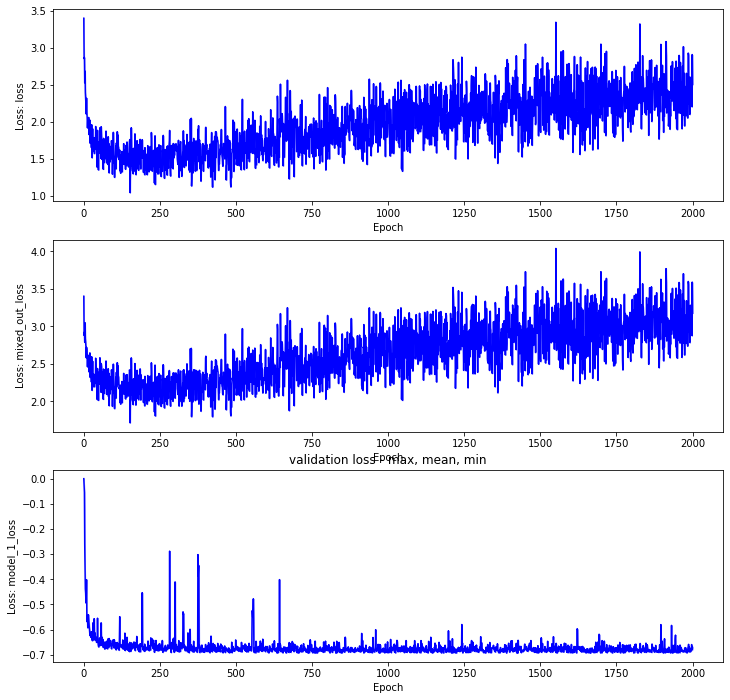

In [0]:
mean_losses = [np.array(v).mean(axis=0) for v in tlm.logs['val_loss']]
max_losses = [np.array(v).max(axis=0) for v in tlm.logs['val_loss']]
min_losses = [np.array(v).min(axis=0) for v in tlm.logs['val_loss']]
epoch = np.arange(len(mean_losses))

fig, axs = plt.subplots(3)
for k in range(3):
  axs[k].plot(epoch, [m[k] for m in mean_losses], color='b')
  axs[k].fill_between(epoch, [m[k] for m in max_losses], [m[k] for m in min_losses], color='b', alpha=0.3)
  axs[k].set_xlabel('Epoch')
  axs[k].set_ylabel('Loss: {}'.format(tlm.train_model.metrics_names[k]))

fig.set_size_inches(12,12)
plt.title('validation loss - max, mean, min')

plt.show()

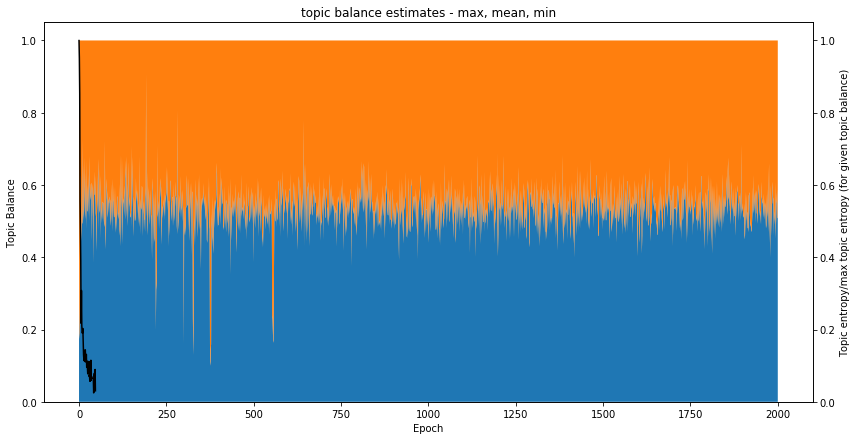

In [0]:
epoch = np.arange(len(tlm.logs['topic_entropy']))

fig, ax_mean = plt.subplots()
ax_mean.stackplot(epoch, np.array(tlm.logs['topic_fraction']).T)
ax_mean.set_xlabel('Epoch')
ax_mean.set_ylabel('Topic Balance')

ax_ent = ax_mean.twinx()
topic_entropy = [e[0] for e in tlm.logs['topic_entropy']]
max_topic_entropy = [(-p*np.log(p)).sum() for p in tlm.logs['topic_fraction']]
frac_topic_entropy = [e/m for e,m in zip(topic_entropy, max_topic_entropy)]
ax_ent.plot(epoch, frac_topic_entropy, color='k')
ax_ent.set_ylabel('Topic entropy/max topic entropy (for given topic balance)')
ax_ent.set_ylim(0,1.05)

fig.set_size_inches(12,6)
fig.tight_layout()
plt.title('topic balance estimates - max, mean, min')

plt.show()